## Train a graph GP model


This notebook provide a simple example to train a graph GP model using a GRF-Diffsuion kernel.

In [11]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import networkx as nx
import numpy as np
from tqdm import tqdm
import torch
from scipy.linalg import expm
import gpytorch
from linear_operator import settings
from gpytorch import settings as gsettings

from grf_gp.utils.spectral import get_normalized_laplacian
from grf_gp.utils.sampling import generate_noisy_samples
from grf_gp.utils.visual import plot_gp_with_subsamples
from grf_gp.utils.config import set_gp_defaults
from grf_gp.kernels.diffusion import GRFDiffusionKernel
from grf_gp.model import GraphGP
from grf_gp.sampler import GRFSampler

### Synthetic dataset (2D regular mesh)

In [12]:
mesh_size = 30
num_nodes = mesh_size**2
adjacency_matrix = nx.adjacency_matrix(nx.grid_2d_graph(mesh_size, mesh_size)).todense()

In [13]:
beta_sample = 10
noise_std = 0.1
kernel_variance = 10.0

In [14]:
def diffusion_kernel(adj_matrix, beta=2):
    """
    Compute the diffusion kernel matrix for a graph.
    """
    laplacian = get_normalized_laplacian(adj_matrix)
    return expm(-beta * laplacian)  # Matrix exponential


In [15]:
K_true = kernel_variance * diffusion_kernel(adjacency_matrix, beta_sample)
Y = generate_noisy_samples(K_true, noise_std=0, seed=0)
Y_noisy = generate_noisy_samples(K_true, noise_std=noise_std, seed=0)
Y_noisy = torch.tensor(Y_noisy, dtype=torch.float32).flatten()
X = torch.arange(num_nodes, dtype=torch.float32)

subsample_factor = 10
torch.manual_seed(42)
train_idx = np.random.choice(num_nodes, num_nodes//subsample_factor, replace=False)
test_idx = np.setdiff1d(np.arange(num_nodes), train_idx)

x_train = X[train_idx]
y_train = Y_noisy[train_idx]
x_test = X[test_idx]
y_test = Y_noisy[test_idx]

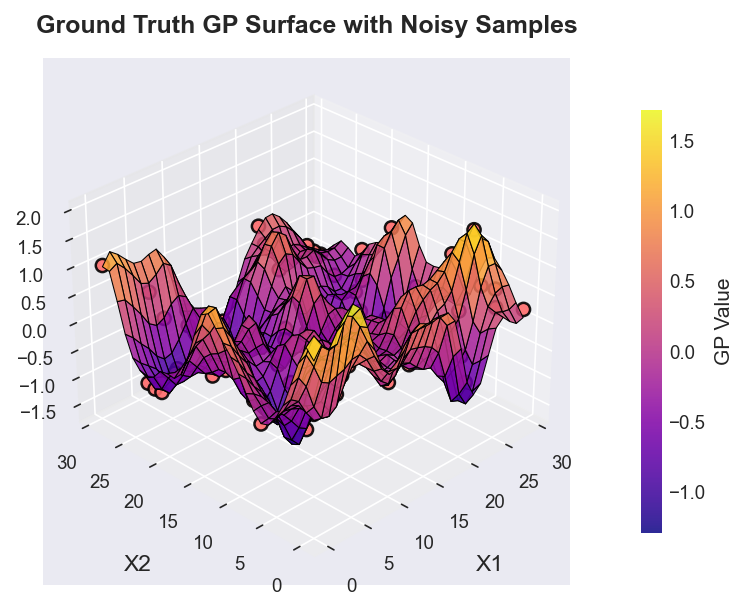

In [ ]:
plot_gp_with_subsamples(Y, mesh_size, train_idx, Y_noisy[train_idx],
                        title='Ground Truth GP Surface with Noisy Samples', cmap='plasma')

### Model

In [17]:
set_gp_defaults(linear_operator_settings=settings,
                gpytorch_settings=gsettings)

In [18]:
MAX_WALK_LENGTH = 4
WALKS_PER_NODE = 1000
P_HALT = 0.1

In [19]:
adj = torch.tensor(get_normalized_laplacian(adjacency_matrix), dtype=torch.float64)
sampler = GRFSampler(adjacency_matrix=adj,
                     walks_per_node=WALKS_PER_NODE,
                     p_halt=P_HALT,
                     max_walk_length=MAX_WALK_LENGTH,
                     n_processes=4)

/Users/matthew/Documents/fast_graph_gp/grf_gp/utils/csr.py:16: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return adjacency.to_sparse_csr()


In [20]:
mats = sampler()

Process walks: 100%|██████████| 225/225 [00:01<00:00, 138.60it/s]


In [ ]:
kernel = GRFDiffusionKernel(max_walk_length=MAX_WALK_LENGTH,
                            rw_mats=mats)

In [22]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GraphGP(x_train=x_train,
                y_train=y_train,
                likelihood=likelihood,
                kernel=kernel)

### Training

In [23]:
STEPS = 1000
LR = 0.01

In [24]:
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for _ in tqdm(range(STEPS)):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/matthew/Documents/fast_graph_gp/venv/lib/python3.11/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/Users/matthew/Documents/fast_graph_gp/venv/lib/python3.11/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:656.)
  res = cls(index_tensor, value_tensor, interp_size)
/Users/matthew/Documents/fast_graph_gp/venv/lib/python3.11/site-packages/linear_operator/utils/spa

### Inference & Visual

In [25]:
INFERENCE_BATCH_SIZE = 1000

In [26]:
posterior_samples = model.predict(X, batch_size=INFERENCE_BATCH_SIZE)
posterior_mean = posterior_samples.mean(dim=0).detach().numpy()
posterior_std = posterior_samples.std(dim=0).detach().numpy()

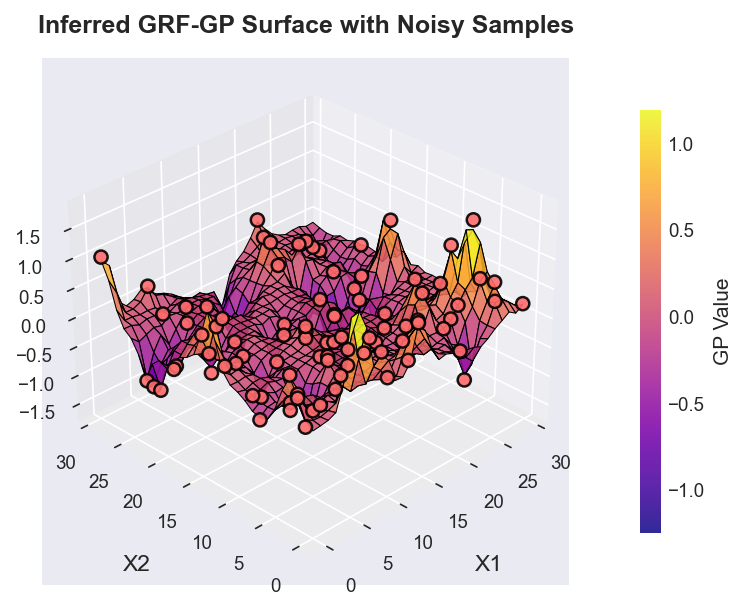

In [27]:
plot_gp_with_subsamples(posterior_mean, mesh_size, train_idx, Y_noisy[train_idx],
                        title='Inferred GRF-GP Surface with Noisy Samples', cmap='plasma')